# Thermostat

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

The following program represents a thermostat that reads the current temperature value and either turns off if it is on and the current temperature is above tOff, or turns on if it is off and the current temperature is below tOn.

```
repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

The temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} -k \cdot \textit{temp} + h \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              -k \cdot \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$


We generate temperature trajectories for $tOn = 17, tOff= 20, k=0.01, h=0.5, \epsilon=0.1$.

Then, starting from a different value of the parameters we optimize the likelihood to find the correct value.

### Generation of the trajectories from the original model

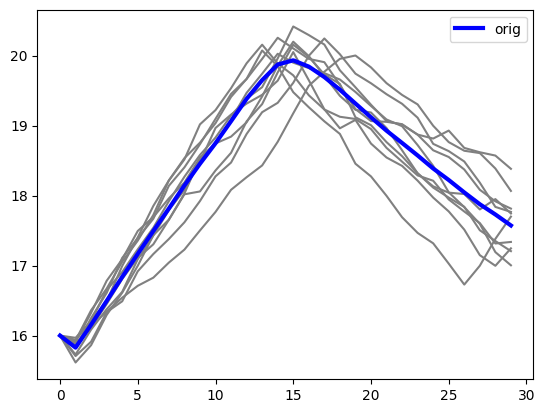

In [1]:
from cps.original_models import *

T = 30 
orig_params = {'T': T,   # time steps
               'init_T': 16.,  # initial temperature
               'tOn': 17,      # turn-on temperature
               'tOff': 20}     # turn-off temperature

orig_traj = generate_traj(thermostat_model, 100, orig_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='orig')

### DeGAS optimization

In [2]:
# import module optimization to use DeGAS

from optimization import *
torch.set_default_dtype(torch.float64)

In [3]:
# COMPILING AND SMOOTHING THE CFG

# Compile SOGA program to a smooth CFG
compiledFile = compile2SOGA('../programs/SOGA/Optimization/CaseStudies/thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# cfg represents now the smoothed program
# The cfg can be explored using the dictionary cfg.node_list

cfg.node_list

{'entry': EntryNode<>,
 'state0': StateNode<state0,None,currT=16,smoothed:currT=16+ gm([1.], [0.], [0.0010000000])>,
 'state1': StateNode<state1,None,isOn=-1,smoothed:isOn=-1+ gm([1.], [0.], [0.0010000000])>,
 'loop0': LoopNode<loop0>,
 'state2': StateNode<state2,True,T[i]=currT,smoothed:T[i]=currT+ gm([1.], [0.], [0.0010000000])>,
 'test0': TestNode<test0,isOn>0,smoothed:isOn > 0 + 0.1581138830>,
 'state3': StateNode<state3,True,newT=0.99*currT+0.5+gm([1.0],[0.000000],[0.100000])>,
 'state4': StateNode<state4,False,newT=0.99*currT+gm([1.0],[0.000000],[0.100000])>,
 'merge0': MergeNode<merge0>,
 'state5': StateNode<state5,None,currT=newT,smoothed:currT=newT+ gm([1.], [0.], [0.0010000000])>,
 'test1': TestNode<test1,isOn>0,smoothed:isOn > 0 + 0.1581138830>,
 'state6': StateNode<state6,True,skip>,
 'test2': TestNode<test2,newT>_tOff>,
 'state7': StateNode<state7,True,isOn=-1,smoothed:isOn=-1+ gm([1.], [0.], [0.0010000000])>,
 'state8': StateNode<state8,False,skip>,
 'merge1': MergeNode<m

In [4]:
# INITIALIZE PARAMETERS 

# initial parameters (different from he correct ones)
init_params = {'tOn':  15., 'tOff':22.}
params_dict = initialize_params(init_params)  

In [5]:
# LOSS DEFINITION
# we use the neg_log_likelihood loss define in the optimization module
idx=list(range(1, T))
loss = lambda dist : neg_log_likelihood(orig_traj, dist, idx)

In [6]:
# OPTIMIZATION
# the function optimize from the module optimization implements and optimization loop using torch Adam optimizer
loss_list, time_opt, n_iters = optimize(cfg, params_dict, loss, n_steps=60, lr=0.1)

tOn: 15.099999999999723 tOff: 21.90000000000031  loss: 8479.770234442922
tOn: 15.200043194119727 tOff: 21.799962186643015  loss: 7737.46122598874
tOn: 15.30002753343633 tOff: 21.700099046333015  loss: 6987.644876796661
tOn: 15.399330053006812 tOff: 21.600608956967196  loss: 6339.214775790735
tOn: 15.497251661642405 tOff: 21.501719665695006  loss: 5766.390036813584
tOn: 15.59356352606392 tOff: 21.40367205591553  loss: 5256.0726890343285
tOn: 15.688420799640244 tOff: 21.30678613785944  loss: 4793.320868319735
tOn: 15.78112552145846 tOff: 21.211389559693572  loss: 4380.887652287728
tOn: 15.86993779380185 tOff: 21.117763793717796  loss: 4043.823941167784
tOn: 15.95289400491661 tOff: 21.026149225094702  loss: 3790.8526020518057
tOn: 16.02876472699278 tOff: 20.936749057035215  loss: 3606.945120670605
tOn: 16.09742070619794 tOff: 20.849729612521987  loss: 3467.3420757766476
tOn: 16.159402652028355 tOff: 20.765234745386245  loss: 3353.0214534989764
tOn: 16.21541177528507 tOff: 20.6834030552764

tOn: 16.77573505961086
tOff: 20.020786698128013


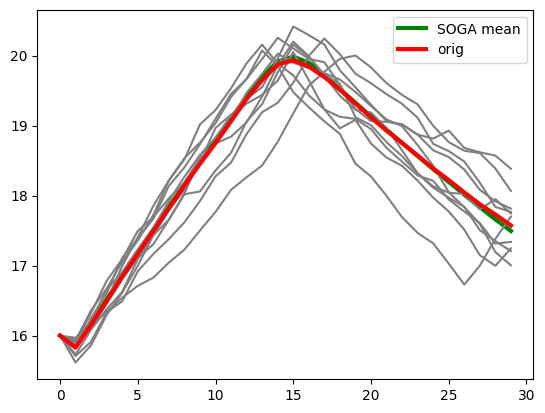

In [7]:
# OPTIMIZATION RESULTS

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

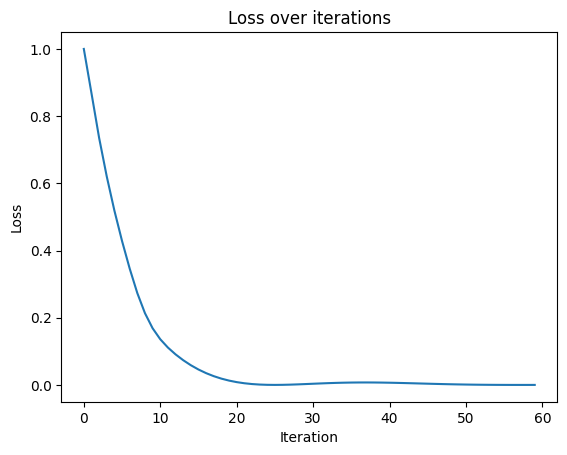

In [8]:
# PRINT LOSS OVER ITERATIONS

loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))

#plot

plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()